In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import torch

In [11]:
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

def intra_class_variance_over_inter_class_variance(vectors, labels):
    vectors = vectors.numpy()
    class_0_vectors = vectors[labels == 0]
    class_1_vectors = vectors[labels == 1]
    class_0_mean = np.mean(class_0_vectors, axis=0)
    class_1_mean = np.mean(class_1_vectors, axis=0)
    class_0_variance = np.mean(np.linalg.norm(class_0_vectors - class_0_mean, axis=1))
    class_1_variance = np.mean(np.linalg.norm(class_1_vectors - class_1_mean, axis=1))
    total_mean = np.mean(vectors, axis=0)
    # return between-class variance over within-class variance
    return (np.linalg.norm(class_0_mean - total_mean) + np.linalg.norm(class_1_mean - total_mean)) / (class_0_variance + class_1_variance)

### Llama3.1 8B, birth_years

In [16]:
df = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/llama3.1_8b_chat/birth_years_4k/base/main_generations_evaluated.csv")
labels = df["correct"].to_numpy()
vars = []
for i in range(0, 31, 2):
    folder_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/llama3.1_8b_chat/birth_years_4k/base/main/prompt_only/layer_" + str(i)
    activation_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")], key=extract_number)
    activations_list = [torch.load(os.path.join(folder_path, f), map_location='cpu').cpu() for f in activation_files]
    activations = torch.cat(activations_list, dim=0)
    var = intra_class_variance_over_inter_class_variance(activations, labels)
    vars.append(var)

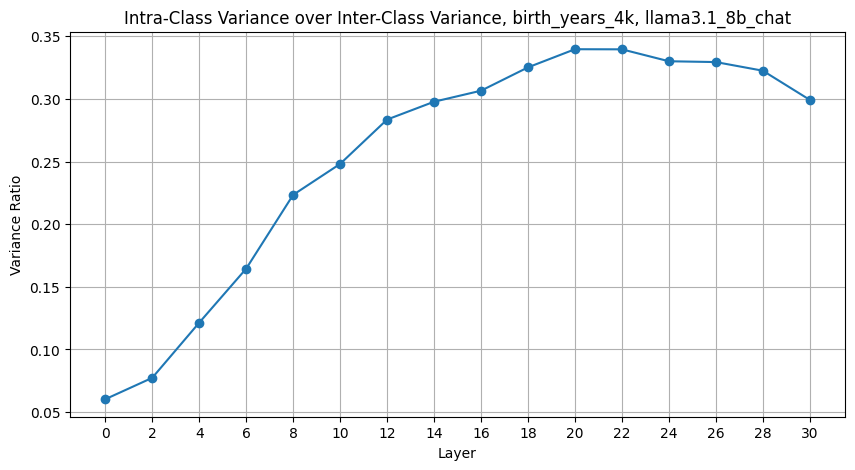

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 31, 2), vars, marker='o')
plt.title('Intra-Class Variance over Inter-Class Variance, birth_years_4k, llama3.1_8b_chat')
plt.xlabel('Layer')
plt.ylabel('Variance Ratio')
plt.xticks(range(0, 31, 2))
plt.grid()
plt.show()

### Mistral 7B, birth_years

In [18]:
df = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/mistral_7b_instruct/birth_years_4k/base/main_generations_evaluated.csv")
labels = df["correct"].to_numpy()
vars = []
for i in range(0, 31, 2):
    folder_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/mistral_7b_instruct/birth_years_4k/base/main/prompt_only/layer_" + str(i)
    activation_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")], key=extract_number)
    activations_list = [torch.load(os.path.join(folder_path, f), map_location='cpu').cpu() for f in activation_files]
    activations = torch.cat(activations_list, dim=0)
    var = intra_class_variance_over_inter_class_variance(activations, labels)
    vars.append(var)

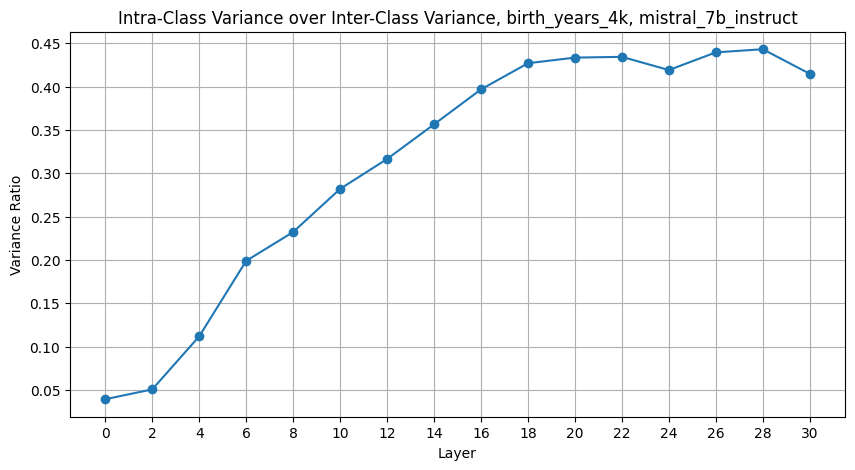

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 31, 2), vars, marker='o')
plt.title('Intra-Class Variance over Inter-Class Variance, birth_years_4k, mistral_7b_instruct')
plt.xlabel('Layer')
plt.ylabel('Variance Ratio')
plt.xticks(range(0, 31, 2))
plt.grid()
plt.show()